In [1]:
## Load data file and generate panadas dataframe

import pandas as pd

df = pd.read_csv('data/XAU_USD Historical Data.csv')

df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/23/2024,"2,329.23","2,321.43","2,334.69","2,317.78",NaN,0.33%
1,06/16/2024,"2,321.51","2,331.27","2,368.77","2,306.66",NaN,-0.47%
2,06/09/2024,"2,332.52","2,296.00","2,341.70","2,287.31",NaN,1.74%
3,06/02/2024,"2,292.71","2,329.61","2,387.85","2,286.77",NaN,-1.47%
4,05/26/2024,"2,326.97","2,334.50","2,364.12","2,321.64",NaN,-0.29%
...,...,...,...,...,...,...,...
152,07/25/2021,"1,814.09","1,802.77","1,832.91","1,792.41",NaN,0.65%
153,07/18/2021,"1,802.34","1,812.09","1,825.75","1,790.98",NaN,-0.53%
154,07/11/2021,"1,811.89","1,808.49","1,834.65","1,791.49",NaN,0.16%
155,07/04/2021,"1,808.98","1,787.99","1,819.10","1,784.29",NaN,1.21%


### Extract the needed dataframe columns (Date and Price)

In [2]:
df = df[['Date', 'Price']]

df

,Date,Price
0,06/23/2024,"2,329.23"
1,06/16/2024,"2,321.51"
2,06/09/2024,"2,332.52"
3,06/02/2024,"2,292.71"
4,05/26/2024,"2,326.97"
...,...,...
152,07/25/2021,"1,814.09"
153,07/18/2021,"1,802.34"
154,07/11/2021,"1,811.89"
155,07/04/2021,"1,808.98"


In [3]:
# inspecting the date column for the datatype
df['Date']

0      06/23/2024
1      06/16/2024
2      06/09/2024
3      06/02/2024
4      05/26/2024
          ...    
152    07/25/2021
153    07/18/2021
154    07/11/2021
155    07/04/2021
156    06/27/2021
Name: Date, Length: 157, dtype: object

### function to convert the 'Date' column datatype from object to datetime

In [4]:
import datetime

def str_to_datetime(s):
  split = s.split('/')
  month, day, year = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('09/01/2021')
datetime_object

datetime.datetime(2021, 9, 1, 0, 0)

In [5]:
df

,Date,Price
0,06/23/2024,"2,329.23"
1,06/16/2024,"2,321.51"
2,06/09/2024,"2,332.52"
3,06/02/2024,"2,292.71"
4,05/26/2024,"2,326.97"
...,...,...
152,07/25/2021,"1,814.09"
153,07/18/2021,"1,802.34"
154,07/11/2021,"1,811.89"
155,07/04/2021,"1,808.98"


In [6]:
# Apply the datetime convertion function to the 'Date' column
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

/tmp/ipykernel_2627978/2565755782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0     2024-06-23
1     2024-06-16
2     2024-06-09
3     2024-06-02
4     2024-05-26
         ...    
152   2021-07-25
153   2021-07-18
154   2021-07-11
155   2021-07-04
156   2021-06-27
Name: Date, Length: 157, dtype: datetime64[ns]

In [7]:
df = df.iloc[::-1] # This reverses the order of the dataframe rows
df.index = df.pop('Date') # This sets the 'Date' column as the dataframe index
df

,Price
Date,
2021-06-27,"1,787.38"
2021-07-04,"1,808.98"
2021-07-11,"1,811.89"
2021-07-18,"1,802.34"
2021-07-25,"1,814.09"
...,...
2024-05-26,"2,326.97"
2024-06-02,"2,292.71"
2024-06-09,"2,332.52"


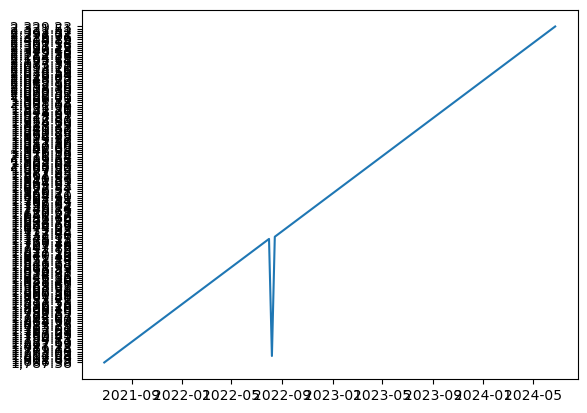

In [8]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Price']) # using matplotlib pyplot to visualize the current state of the prepared dataframe

### Function to prepare the data to use the records from the previous three days to predict the price of the next day

In [9]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  #dataframe = dataframe.iloc[::-1]
  #print(dataframe)
  #print(dataframe)
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Price'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Testing the function above
# Start day second time around: '03/25/2021'
windowed_df = df_to_windowed_df(df,
                                '10/31/2021',
                                '05/26/2024', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-10-31,"1,767.59","1,793.01","1,783.39","1,817.73"
1,2021-11-07,"1,793.01","1,783.39","1,817.73","1,864.57"
2,2021-11-14,"1,783.39","1,817.73","1,864.57","1,845.60"
3,2021-11-21,"1,817.73","1,864.57","1,845.60","1,792.07"
4,2021-11-28,"1,864.57","1,845.60","1,792.07","1,784.07"
...,...,...,...,...,...
130,2024-04-28,"2,343.43","2,390.45","2,337.72","2,301.56"
131,2024-05-05,"2,390.45","2,337.72","2,301.56","2,360.14"
132,2024-05-12,"2,337.72","2,301.56","2,360.14","2,414.89"
133,2024-05-19,"2,301.56","2,360.14","2,414.89","2,333.76"


### Function to extract the shape of the variables from the windowed_dataframe to be used for training and prediction

In [10]:

def windowed_df_to_date_X_y(windowed_dataframe):
  windowed_dataframe = windowed_dataframe.applymap(lambda x: float(str(x).replace(",", "")) if isinstance(x, str) else x) # remove number formating ','
  df_as_np = windowed_dataframe.to_numpy() # convert the dataframe to numpy

  dates = df_as_np[:, 0] # Extract the date column

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) # Extract the set of colums with the previous prices

  Y = df_as_np[:, -1] # Extract the Target column

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((135,), (135, 3, 1), (135,))

###  Visualize the windowed_df_to_date_X_y along the 80th and 90th percentile for the training and validation respectively

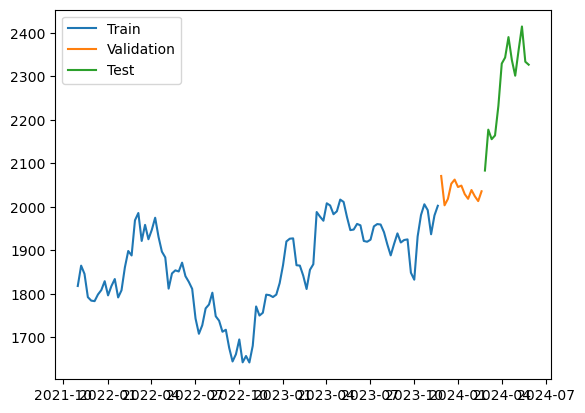

In [11]:
# Split the dates column along the 80th and 90th percentile for the training and validation respectively
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
### Prepare the windowed_df_to_date_X_y for Recursive neural network modeling using TensorFlow and Keras

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

ModuleNotFoundError: No module named 'tensorflow'

### Prediction and visualization of training data i.e the three previous days' price column using the 80th percentile

In [15]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

NameError: name 'model' is not defined

### Prediction and visualization of validation data i.e the three previous days' price column using the 90th percentile

In [16]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

NameError: name 'model' is not defined

### Prediction visualization of testing data i.e the three previous days' price column using the remaning 10th percentile

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
# visualization of Training, Validation and Testing Data
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

### Next Prediction price and visualization

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])